In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage
import sys
sys.path.append('/Users/siljegrue/Library/CloudStorage/OneDrive-UiTOffice365/Desktop/uit/Article 2023/Code/Article_2023_MASSIMAL//')
import batch_processes, annotation, hyspec_io
import h5py

In [3]:
#Paths South side

from paths import *

hyspec_dir = hyspec_dir_south
annotation_dir = annotation_dir_south_greyscale
json_gray = json_gray

In [4]:
# Read annotation metadata file, show classes
class_dict = annotation.read_hasty_metadata(json_gray)

In [5]:
# Collect annotated images 

data = batch_processes.collect_annotated_data(class_dict,hyspec_dir,annotation_dir)


# list of dicts for the images that are in the folder
# Collect datasets in dict with keys:
    # hyspec_file
    # annotation_file
    # nonzero_mask 
    # annotation_mask
    # spectra
# the spectra is a dict with keys that corresponds to all classes.
# each key wil give the collected pixels for that class in that image,
# stored in an array with shape [n,173], where n is the number of annotated pixels in that image

Processing file: OlbergholmenS_Pika_L_1-Radiance From Raw Data-Georectify Airborne Datacube
Processing file: OlbergholmenS_Pika_L_10-Radiance From Raw Data-Georectify Airborne Datacube
Processing file: OlbergholmenS_Pika_L_11-Radiance From Raw Data-Georectify Airborne Datacube
Processing file: OlbergholmenS_Pika_L_12-Radiance From Raw Data-Georectify Airborne Datacube
Processing file: OlbergholmenS_Pika_L_15-Radiance From Raw Data-Georectify Airborne Datacube
Processing file: OlbergholmenS_Pika_L_16-Radiance From Raw Data-Georectify Airborne Datacube
Processing file: OlbergholmenS_Pika_L_17-Radiance From Raw Data-Georectify Airborne Datacube
Processing file: OlbergholmenS_Pika_L_18-Radiance From Raw Data-Georectify Airborne Datacube
Processing file: OlbergholmenS_Pika_L_2-Radiance From Raw Data-Georectify Airborne Datacube
Processing file: OlbergholmenS_Pika_L_23-Radiance From Raw Data-Georectify Airborne Datacube
Processing file: OlbergholmenS_Pika_L_24-Radiance From Raw Data-Georecti

In [6]:
# List of names of all classes in the dataset
names = []
for name in class_dict.keys():
	names.append(name)
print(names)

['Sand', 'Gravel', 'Mud', 'Terrestrial', 'Zostera marina - dominant', 'Zostera marina - normal', 'Zostera marina - sparse', 'Zostera marina with turf algae', 'Turf algae - dominant', 'Turf algae - normal', 'Turf algae - sparse', 'Rockweed', 'Rockweed with turf algae', 'Fucus serratus', 'Aegagropila (algae ball)', 'Mixed algae classes on soft substrate', 'Saccharina latissima']


In [25]:
"""Extract annotated pixels in the dataset"""

#Loop through all images in the dataset, check which classes are annotated
#in that image, and store those pixels in an array 

def extract_annotated_pixels(data):
    
    """Extract annoated pixels in the dataset by looping thruogh all images in the dataset and 
    store those pixels in an array with the corresponding class
    
    data = dataset; images stored in a dict with keys:
    # hyspec_file
    # annotation_file
    # nonzero_mask 
    # annotation_mask
    # spectra
    
    
    returns:
    annotated_pixels = array with all annotated pixels [n x 173]
    class_labels = array with corresponding class labels [n]
    """
    
    
    
    class_labels = [] # to store all class labels in
    classes_in_dataset = [] # need to store them later
    counter = 0
    for data_dict in data:    #loop through all images in the dataset
        
        
        
        spectra = data_dict["spectra"] # the spectra (pixels values for each spectral band) for this image
        
        
        for n in names:  # loop through all classes
        
            spec = spectra[n]  # spectral information for class n, for each pixel in class n
            X = []   # to store annoated pixels in
            
            if spec.size > 0: 
      # if <0: then no annotated pixels for this class
      # if >0: then there are annotated pixels in this class in this image
                
                if n not in classes_in_dataset:
                    classes_in_dataset.append(n) 
                    
                X.append(spec) # store the annotated pixels from class n
                X = np.array(X).reshape((len(X[0]),173)) #store pixels in an array rather than list
       
        
        # spec.shape[0] = the number of annotated pixels from class n
        # therefore, store the class name (n) times spec.shape[0] 
                
                class_labels.append([n] * spec.shape[0]) 
                
                
               
     
    # store all extracted pixels for this image in an array
    
    
                if counter == 0:
                    annotated_pixels = X
            
                else:
                    annotated_pixels = np.concatenate((annotated_pixels,X),axis=0)  # annorated pixels
                counter += 1
    
    
    class_labels = [ item for elem in class_labels for item in elem]
    class_labels = np.array(class_labels)
  
    
    return annotated_pixels , class_labels

In [45]:
"""Extract annotated pixels and their corresponding class labels from dataset"""
annotated_pixels, class_labels = extract_annotated_pixels(data)

# Identify which classes are annotated in the dataset (not all classes are represented)
classes_in_dataset = np.unique(class_labels)
print(classes_in_dataset)

['Aegagropila (algae ball)' 'Fucus serratus'
 'Mixed algae classes on soft substrate' 'Rockweed with turf algae'
 'Saccharina latissima' 'Sand' 'Turf algae - dominant'
 'Zostera marina - dominant' 'Zostera marina with turf algae']


In [29]:
"""Define merged classes"""
z_m =  ['Zostera marina - dominant']
z_m_t = ['Zostera marina with turf algae']
sand = ['Sand']
kelp = ['Fucus serratus', 'Rockweed with turf algae', 'Saccharina latissima']
other = ['Aegagropila (algae ball)', 'Turf algae - dominant' ]
mixed = ['Mixed algae classes on soft substrate'] #(this class will not be part of the training/validation)


"""Merge classes"""

class_labels_copy = class_labels   # creating a copy of the original dataset labels 


# z_m
class_labels_copy[class_labels_copy == 'Zostera marina - dominant' ] = "z_m"

# z_m_d
class_labels_copy[class_labels_copy == 'Zostera marina with turf algae' ] = "z_m_d"

# kelp
class_labels_copy[class_labels_copy == 'Rockweed with turf algae' ] = "kelp"
class_labels_copy[class_labels_copy == 'Fucus serratus' ] = "kelp"
class_labels_copy[class_labels_copy == 'Saccharina latissima' ] = "kelp"

# other
class_labels_copy[class_labels_copy == 'Aegagropila (algae ball)' ] = "other"
class_labels_copy[class_labels_copy == 'Mixed algae classes on soft substrate' ] = "other"
class_labels_copy[class_labels_copy == 'Turf algae - dominant' ] = "other"


# mixed
class_labels_copy[class_labels_copy == 'Mixed algae classes on soft substrate' ] = "mixed"



In [60]:
#print(classes_in_dataset[1])
i = classes_in_dataset[2]
print(i)
print(class_labels[class_labels == i ].shape)

Mixed algae classes on soft substrate
(20658,)


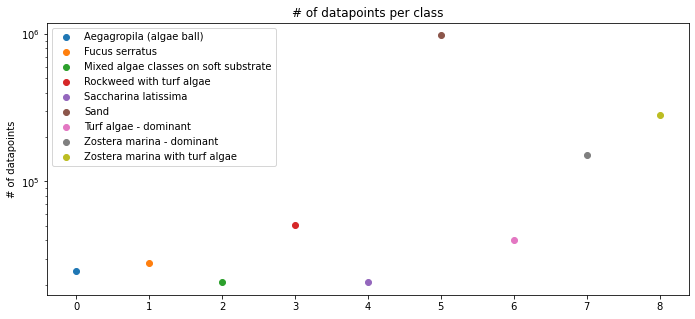

In [79]:
# Plot the distribution of the classes in the dataset
l = []
for i in range(len(classes_in_dataset)):
    class_name = classes_in_dataset[i]
    n = class_labels[class_labels == class_name ].shape[0]
    plt.scatter(i,n, label = class_name)
    l.append(n)
plt.legend()
plt.ylabel("# of datapoints")
plt.title("# of datapoints per class")
plt.yscale('log')   # to scale the plot and make it easier to read
plt.rcParams["figure.figsize"] = (11, 5) 
plt.show()

PCA

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [32]:
# create pca model 
X =  StandardScaler().fit_transform(annotated_pixels)  # standardize dataset
pca = PCA(n_components = 25)    
X_pca = pca.fit_transform(X)    

In [33]:
X_pca.shape

(1597197, 25)